# Import

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Exploration

Chargez le dataset IMDB via pandas. (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews.) 
- Ce dataset tres connu rassemble des critiques de films de spectateurs
- L'objectif est d'entrainer un modèle de NLP à détecter si la critique est positive ou negative

In [5]:
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Explorons ce jeu de données. Parmi les questions que vous pouvez vous poser :
- Combien y-t-il d'elements ?
- Quel est le langage ? A quoi ressemble les commentaires ? 
- Quelles longueur font les commentaires (moyenne ou mieux, visualiser la répartition du nombre de mots) ?
- Y-a-t-il suffisamment d'élements pour la tache ?
- est-il équilibré ? combien de critiques positives ou negatives ?

In [6]:
f"Le dataset contient {data.shape[0]} critiques"

'Le dataset contient 50000 critiques'

In [7]:
data.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

C'est de l'anglais.

Observons la différence de longueur  des reviews

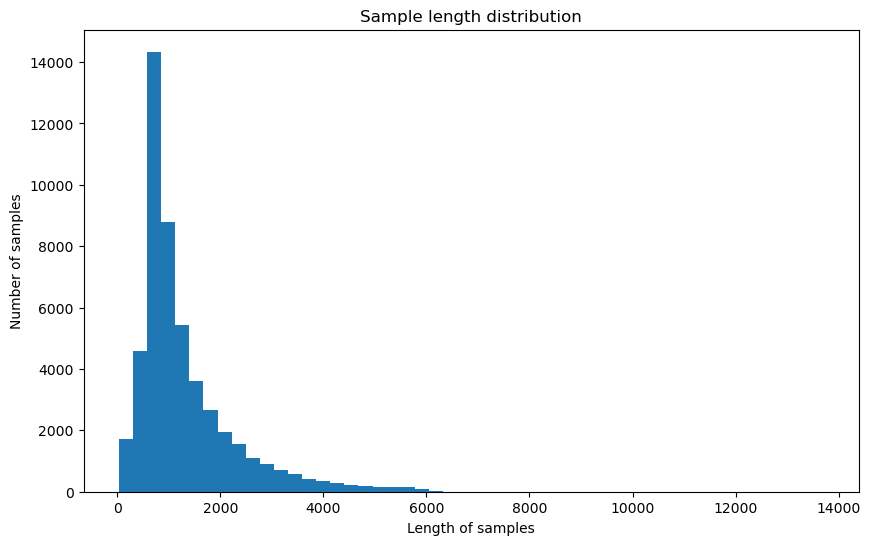

In [8]:
# Now, let's see the average number of words per sample
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(data['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

La question de suffisamment d'élément est souvent impossible à répondre avant de faire des premiers tests :
- elle dépend de la complexité des critiques
- elle dépend du modèle que l'on veut utiliser
- elle dépend des performances visées

Les classes sont elles équilibrées ? 

In [18]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

# Séparation

Il nous faut maintenant extraire et encoder les labels. Vous pouvez utiliser LabelEncoder de scikit learn pour le faire.

In [19]:
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])
y

array([1, 1, 1, ..., 0, 0, 0])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data["review"], y, test_size=0.2, random_state=42)

# Nettoyage 

Utilisons un bag of word pour encoder les textes. La classe correspondante dans scikit-learn est CountVectoriser. 
Son paramètre max_feature permet de limiter le nombre de colonnes créées si besoin (RAM, temps de calcul, mots peu importants, ...).

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000 )
X_train_bow = vectorizer.fit_transform(X_train).todense()
X_val_bow = vectorizer.transform(X_val).todense()
f"On obtient {X_train_bow.shape[1]} colonnes, chacune encodant le nombre d'occurence d'un mot dans les commentaires"

"On obtient 1000 colonnes, chacune encodant le nombre d'occurence d'un mot dans les commentaires"

# Création du model avec Keras

In [13]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow import keras

In [14]:
X_train_bow.shape

(40000, 1000)

In [15]:
dropout_rate = 0.2
input_shape = X_val_bow.shape[1]



input_layer = Input([input_shape])
out_layer = Dropout(rate=dropout_rate)(input_layer)
out_layer = Dense(units=10, activation='relu')(out_layer)
out_layer = Dropout(rate=dropout_rate)(out_layer)
out_layer = Dense(units=1, activation="sigmoid")(out_layer)


model = keras.Model(inputs=input_layer, outputs=out_layer)
model.build([input_shape])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10010     
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10,021
Trainable params: 10,021
Non-trainable params: 0
_________________________________________________________________


## Compilation

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10010     
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10,021
Trainable params: 10,021
Non-trainable params: 0
_________________________________________________________________


# Entrainement

In [17]:
# Pour ajouter des comportements additionnels appelés lors de l'entrainement. Par exemple des logs, de l'early stopping, ou tout méthode custom
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2)]
epochs = 10
batch_size = 100


history = model.fit(X_train_bow, 
                    y_train, 
                    epochs=epochs, 
                    validation_data=(X_val_bow, y_val), 
                    verbose=1, 
                    batch_size=batch_size, 
                    callbacks=callbacks)

Epoch 1/10
400/400 [==============================] - 2s 3ms/step - loss: 0.5260 - acc: 0.7392 - val_loss: 0.3569 - val_acc: 0.8594
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3918 - acc: 0.8333 - val_loss: 0.3262 - val_acc: 0.8684
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3661 - acc: 0.8448 - val_loss: 0.3127 - val_acc: 0.8659
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3565 - acc: 0.8480 - val_loss: 0.3059 - val_acc: 0.8691
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3486 - acc: 0.8515 - val_loss: 0.3125 - val_acc: 0.8640
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3414 - acc: 0.8523 - val_loss: 0.3049 - val_acc: 0.8697
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.3401 - acc: 0.8550 - val_loss: 0.3088 - val_acc: 0.8658
Epoch 8/10
400/400 [==============================] - 1s 3ms/step - loss: 0.

On constate que notre modèle stagne assez vite, probablement lié au fait du faible volume de données, peut-être que l'on peut augmenter le nombre de features ou améliorer l'architecture du réseau ?

# Analyse des résultats

In [34]:
y_val_pred = model.predict(X_val_bow)

313/313 [==============================] - 0s 836us/step


In [35]:
y_val_pred

array([[0.03702954],
       [0.771409  ],
       [0.22575592],
       ...,
       [0.82363194],
       [0.20003608],
       [0.91108435]], dtype=float32)

In [36]:
y_val_pred = y_val_pred > 0.9

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_val, y_val_pred)
print(cf_matrix)

[[4890   71]
 [2476 2563]]


0 : sentiment negatif
1 : sentiment positif

Sur quelle classe le modele performe-t-il le mieux ?

<AxesSubplot: >

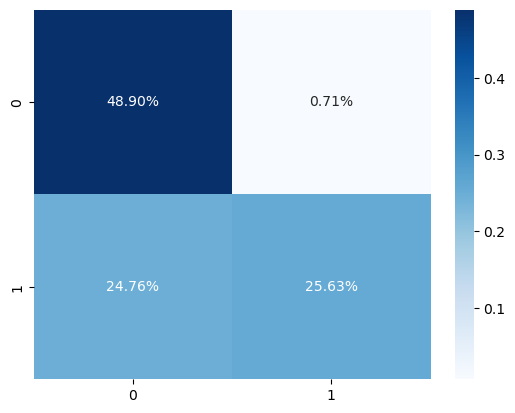

In [38]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Y a t'il une longuer de review à partir de laquelle on prédit moins bien ?

In [39]:
lens = np.array([len(x) for x in X_val])

In [40]:
is_correct = y_val == y_val_pred.flatten()

In [41]:
incorrect_lens = lens[~is_correct]

(array([ 545., 1078.,  414.,  218.,  131.,   69.,   43.,   23.,   12.,
          14.]),
 array([  65. ,  660.5, 1256. , 1851.5, 2447. , 3042.5, 3638. , 4233.5,
        4829. , 5424.5, 6020. ]),
 <BarContainer object of 10 artists>)

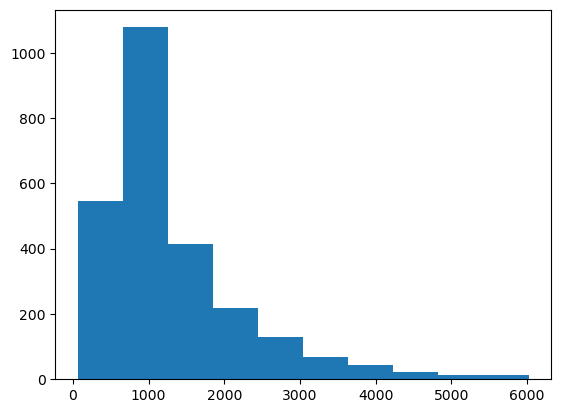

In [42]:
plt.hist(incorrect_lens)

(array([2.353e+03, 2.981e+03, 1.031e+03, 4.870e+02, 2.720e+02, 1.430e+02,
        8.900e+01, 7.200e+01, 2.400e+01, 1.000e+00]),
 array([  41. ,  753.3, 1465.6, 2177.9, 2890.2, 3602.5, 4314.8, 5027.1,
        5739.4, 6451.7, 7164. ]),
 <BarContainer object of 10 artists>)

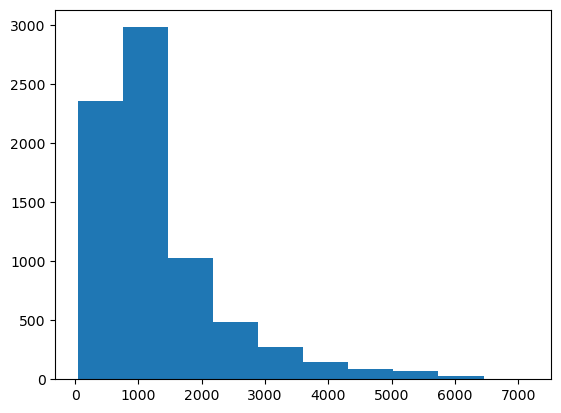

In [43]:
plt.hist(lens[is_correct])